In [2]:
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine
from datetime import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

%config InlineBackend.figure_format = 'svg'
%matplotlib inline 

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt" #url with formatting to fill in the number of the particular week
    dfs = []
    for week_num in week_nums: #for each week
        file_url = url.format(week_num) #format the url so it grabs that week
        dfs.append(pd.read_csv(file_url)) #append to our empty list
    return pd.concat(dfs) #combine files for each week


start_date = '12/29/2018'
num_per = 24
data_collection_period = pd.date_range(start = start_date, periods = num_per, freq = 'W-SAT')

week_nums = []
for item in data_collection_period:
    week_nums.append(str(item.date()).replace('-','')[2:])

turnstiles_df = get_data(week_nums) #use our function to get a df with all of our data

In [ ]:
csv_filename = f'mta_data_{week_nums[0]}_to_{week_nums[-1]}.csv'
turnstiles_df.to_csv(csv_filename, header = False, index = False)

In [3]:
engine = create_engine("sqlite:///mta.db")
all_data = pd.read_sql('SELECT * FROM mta_data_2019;', engine)

In [4]:
#add a column with dtype datetime64 with combined date and time
all_data['DATE_TIME'] = pd.to_datetime(all_data.DATE + " " + all_data.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [5]:
#create a new column categorizing the time of day into night, morning, afternoon, evening
all_data['TIME_OF_DAY'] = pd.cut(all_data.DATE_TIME.dt.hour,
                                bins = [0, 3, 6, 9, 12, 15, 18, 21, 24],
                                labels = ['Late Night', 'Early Morning', 'Morning', 'Mid-Morning', 'Early Afternoon', 'Late Afternoon', 'Evening', 'Night'],
                                right = False,
                                include_lowest = True)

In [6]:
#look for duplicate values (same turnstile with two entries for same timestamp)
(all_data
 .groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values(["ENTRIES", "STATION"], ascending=[False, True])).head()

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
4068394,R306,R207,00-00-00,135 ST,2019-04-08 16:00:00,2
4069382,R306,R207,00-00-01,135 ST,2019-04-08 16:00:00,2
121837,A034,R170,03-03-00,14 ST-UNION SQ,2019-03-12 17:00:00,2
128012,A035,R170,00-00-00,14 ST-UNION SQ,2019-03-27 17:00:00,2
129032,A035,R170,00-00-01,14 ST-UNION SQ,2019-03-27 17:00:00,2


In [7]:
#examining a specific turnstile to look at duplicates
mask = ((all_data["CA"] == "R306") & 
(all_data["UNIT"] == "R207") & 
(all_data["SCP"] == "00-00-01") & 
(all_data["STATION"] == "135 ST") &
(all_data["DATE_TIME"].dt.date == datetime(2019, 4, 8).date()))

all_data[mask].head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY
3214454,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,00:00:00,REGULAR,1691175,224569,2019-04-08 00:00:00,Late Night
3214455,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,04:00:00,REGULAR,1691192,224574,2019-04-08 04:00:00,Early Morning
3214456,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,08:00:00,REGULAR,1691539,224618,2019-04-08 08:00:00,Morning
3214457,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,08:54:41,REGULAR,1691845,224650,2019-04-08 08:54:41,Morning
3214458,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,12:00:00,REGULAR,1692248,224689,2019-04-08 12:00:00,Early Afternoon


In [8]:
all_data.DESC.value_counts()

REGULAR       4864888
RECOVR AUD      21903
Name: DESC, dtype: int64

In [9]:
#remove duplicate values
all_data.sort_values(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace = True, ascending = False)
all_data.drop_duplicates(subset = ["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace = True)

In [10]:
(all_data
 .groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2018-12-22 03:00:00,1
3257780,R141,R031,00-03-01,34 ST-PENN STA,2019-04-02 20:00:00,1
3257778,R141,R031,00-03-01,34 ST-PENN STA,2019-04-02 12:00:00,1
3257777,R141,R031,00-03-01,34 ST-PENN STA,2019-04-02 08:00:00,1
3257776,R141,R031,00-03-01,34 ST-PENN STA,2019-04-02 04:00:00,1


In [11]:
all_data['LINENAME'].nunique()

114

In [12]:
#sort the line names uniformly so that common values are used to group appropriately
all_data['LINENAME'] = all_data['LINENAME'].apply(lambda x : ''.join(sorted(x)))

In [13]:
all_data['LINENAME'].nunique()

95

In [14]:
turnstiles_daily = all_data.groupby(['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE'], as_index = False).first()

In [15]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["CA", "UNIT", "SCP", "STATION", 'LINENAME'])[["DATE", "ENTRIES"]]
                                                       .shift(1))

In [16]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis = 0, inplace = True)

In [17]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804813 entries, 1 to 809750
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   CA            804813 non-null  object        
 1   UNIT          804813 non-null  object        
 2   SCP           804813 non-null  object        
 3   STATION       804813 non-null  object        
 4   LINENAME      804813 non-null  object        
 5   DATE          804813 non-null  object        
 6   DIVISION      804813 non-null  object        
 7   TIME          804813 non-null  object        
 8   DESC          804813 non-null  object        
 9   ENTRIES       804813 non-null  int64         
 10  EXITS         804813 non-null  int64         
 11  DATE_TIME     804813 non-null  datetime64[ns]
 12  TIME_OF_DAY   804813 non-null  category      
 13  PREV_DATE     804813 non-null  object        
 14  PREV_ENTRIES  804813 non-null  float64       
dtypes: category(1), d

In [18]:
#identify rows that are comparing readings from different devices and set to nan
turnstiles_daily.mask(turnstiles_daily['SCP'] != turnstiles_daily['SCP'].shift(1), inplace = True)

In [19]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804813 entries, 1 to 809750
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   CA            799885 non-null  object        
 1   UNIT          799885 non-null  object        
 2   SCP           799885 non-null  object        
 3   STATION       799885 non-null  object        
 4   LINENAME      799885 non-null  object        
 5   DATE          799885 non-null  object        
 6   DIVISION      799885 non-null  object        
 7   TIME          799885 non-null  object        
 8   DESC          799885 non-null  object        
 9   ENTRIES       799885 non-null  float64       
 10  EXITS         799885 non-null  float64       
 11  DATE_TIME     799885 non-null  datetime64[ns]
 12  TIME_OF_DAY   799885 non-null  category      
 13  PREV_DATE     799885 non-null  object        
 14  PREV_ENTRIES  799885 non-null  float64       
dtypes: category(1), d

In [20]:
turnstiles_daily.dropna(how = 'all', inplace = True)

In [21]:
(turnstiles_daily["ENTRIES"] - turnstiles_daily["PREV_ENTRIES"]).describe()

count    7.998850e+05
mean    -1.798119e+03
std      1.272646e+07
min     -2.071639e+09
25%      2.190000e+02
50%      7.400000e+02
75%      1.482000e+03
max      2.088504e+09
dtype: float64

In [22]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].sample(5)
#First day is comparing the wrong dates - comparing the first day values to the values from the last day in the data
#set. After running diff to get daily entries, drop the rows where the date is more than 1 day beyond previous
#entry.
#Some counters may also be rolling over.

,CA,UNIT,SCP,STATION,LINENAME,DATE,DIVISION,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY,PREV_DATE,PREV_ENTRIES
382185,N505,R022,02-00-03,34 ST-HERALD SQ,BDFMNQRW,12/22/2018,IND,23:00:00,REGULAR,8.901130e+06,5.355311e+06,2018-12-22 23:00:00,Night,06/07/2019,9.133255e+06
34611,A049,R088,02-05-00,CORTLANDT ST,NRW,02/05/2019,BMT,20:00:00,REGULAR,1.058666e+09,2.287209e+07,2019-02-05 20:00:00,Evening,02/04/2019,1.058666e+09
686121,R322,R386,00-00-02,174 ST,25,02/09/2019,IRT,20:00:00,REGULAR,6.888138e+08,3.013573e+08,2019-02-09 20:00:00,Evening,02/08/2019,6.888145e+08
292161,N215,R237,00-00-02,182-183 STS,BD,02/17/2019,IND,23:00:00,REGULAR,1.476092e+09,1.845622e+09,2019-02-17 23:00:00,Night,02/16/2019,1.476093e+09
205690,N063A,R011,00-00-05,42 ST-PORT AUTH,1237ACENQRSW,05/23/2019,IND,20:00:00,REGULAR,1.556093e+09,9.242308e+08,2019-05-23 20:00:00,Evening,05/22/2019,1.556097e+09


In [23]:
mask = ((all_data["CA"] == "N063A") & 
(all_data["UNIT"] == "R011") & 
(all_data["SCP"] == "00-00-04") & 
(all_data["STATION"] == "42 ST-PORT AUTH") &
(all_data["DATE_TIME"].dt.date == datetime(2019, 5, 6).date()))

In [24]:
#entries are going down, exits are increasing
all_data[mask].sort_values('DATE_TIME')[['DATE', 'TIME', 'ENTRIES', 'EXITS']]

,DATE,TIME,ENTRIES,EXITS
3913724,05/06/2019,00:00:00,45169553,806301890
3913725,05/06/2019,04:00:00,45169538,806301894
3913726,05/06/2019,08:00:00,45168581,806301921
3913727,05/06/2019,12:00:00,45167075,806302021
3913728,05/06/2019,16:00:00,45166650,806302187
3913729,05/06/2019,20:00:00,45165937,806302699


In [25]:
turnstiles_daily['DAILY_ENTRIES'] = turnstiles_daily['ENTRIES'].diff()

In [26]:
turnstiles_daily['DAILY_EXITS'] = turnstiles_daily['EXITS'].diff()

In [27]:
mask = turnstiles_daily['DAILY_ENTRIES'] >= 0
turnstiles_daily[mask].describe()

,ENTRIES,EXITS,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS
count,7.854280e+05,7.854280e+05,7.854280e+05,7.854280e+05,7.854280e+05
mean,3.039682e+07,2.446091e+07,3.032974e+07,2.800316e+05,2.132620e+05
std,1.685522e+08,1.583540e+08,1.683185e+08,1.803072e+07,1.627408e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.960883e+09
25%,3.744598e+05,1.582420e+05,3.717835e+05,2.430000e+02,1.410000e+02
50%,2.225367e+06,1.280946e+06,2.220132e+06,7.600000e+02,4.840000e+02
75%,6.617304e+06,4.528176e+06,6.610192e+06,1.505000e+03,1.096000e+03
max,2.129558e+09,2.124341e+09,2.129547e+09,2.121491e+09,2.107588e+09


In [28]:
#need to isolate where prev date isn't one day before current date and remove those rows
turnstiles_daily['DATE_TO_COMPARE'] = pd.to_datetime(turnstiles_daily['PREV_DATE'], format = "%m/%d/%Y") + pd.Timedelta(1, unit = "d")

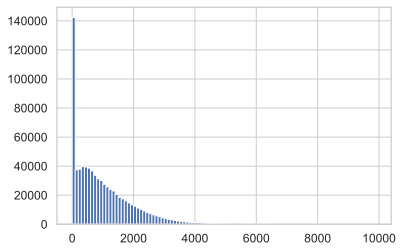

In [33]:
plt.hist(turnstiles_daily['DAILY_ENTRIES'], bins = np.arange(0, 10000, 100));

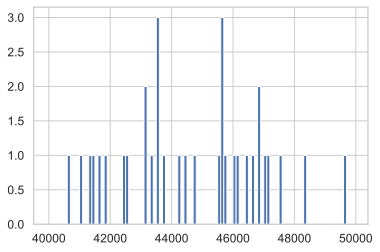

In [36]:
plt.hist(turnstiles_daily['DAILY_ENTRIES'], bins = np.arange(40000, 50000, 100));

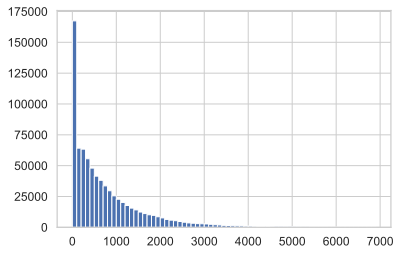

In [37]:
plt.hist(turnstiles_daily['DAILY_EXITS'], bins = np.arange(0, 7000, 100));

In [38]:
# mask = (turnstiles_daily['DATE'] != turnstiles_daily['DATE_TO_COMPARE'])
# turnstiles_daily[mask].info()
turnstiles_daily.mask(turnstiles_daily['DATE'] != turnstiles_daily['DATE_TO_COMPARE'], inplace = True)

In [39]:
turnstiles_daily.dropna(subset = ['DAILY_ENTRIES'], inplace = True)

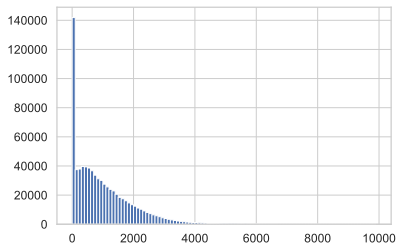

In [40]:
#examining distribution of entries to determine a cut off for real values of entries
plt.hist(turnstiles_daily['DAILY_ENTRIES'], bins = np.arange(0, 10000, 100));

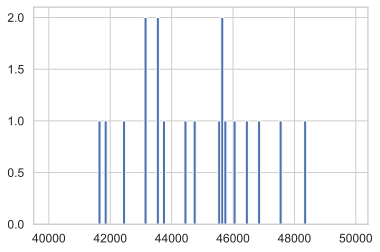

In [41]:
plt.hist(turnstiles_daily['DAILY_ENTRIES'], bins = np.arange(40000, 50000, 100));

In [42]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794158 entries, 3 to 809750
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   CA               794158 non-null  object        
 1   UNIT             794158 non-null  object        
 2   SCP              794158 non-null  object        
 3   STATION          794158 non-null  object        
 4   LINENAME         794158 non-null  object        
 5   DATE             794158 non-null  object        
 6   DIVISION         794158 non-null  object        
 7   TIME             794158 non-null  object        
 8   DESC             794158 non-null  object        
 9   ENTRIES          794158 non-null  float64       
 10  EXITS            794158 non-null  float64       
 11  DATE_TIME        794158 non-null  datetime64[ns]
 12  TIME_OF_DAY      794158 non-null  category      
 13  PREV_DATE        794158 non-null  object        
 14  PREV_ENTRIES     794

In [43]:
turnstiles_daily.mask(turnstiles_daily['DAILY_ENTRIES'] > 50000, inplace = True)
turnstiles_daily.mask(turnstiles_daily['DAILY_ENTRIES'] < 0, inplace = True)

In [44]:
turnstiles_daily.dropna(subset = ['DAILY_ENTRIES'], inplace = True)

In [45]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781530 entries, 3 to 809750
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   CA               781530 non-null  object        
 1   UNIT             781530 non-null  object        
 2   SCP              781530 non-null  object        
 3   STATION          781530 non-null  object        
 4   LINENAME         781530 non-null  object        
 5   DATE             781530 non-null  object        
 6   DIVISION         781530 non-null  object        
 7   TIME             781530 non-null  object        
 8   DESC             781530 non-null  object        
 9   ENTRIES          781530 non-null  float64       
 10  EXITS            781530 non-null  float64       
 11  DATE_TIME        781530 non-null  datetime64[ns]
 12  TIME_OF_DAY      781530 non-null  category      
 13  PREV_DATE        781530 non-null  object        
 14  PREV_ENTRIES     781

In [46]:
station_daily = turnstiles_daily.groupby(['STATION','LINENAME', 'DATE'])['DAILY_ENTRIES'].sum().reset_index()
station_daily.head()

,STATION,LINENAME,DATE,DAILY_ENTRIES
0,1 AV,L,01/04/2019,20389.0
1,1 AV,L,01/05/2019,13930.0
2,1 AV,L,01/06/2019,12021.0
3,1 AV,L,01/07/2019,19538.0
4,1 AV,L,01/08/2019,20414.0


In [ ]:
#looking at individual stations
# station_daily[station_daily['STATION'] == 'GRD CNTRL-42 ST'].head(10)

In [47]:
station_daily['STATION_AND_LINE'] = station_daily['STATION'] + ' ' + station_daily['LINENAME']

In [48]:
station_totals = station_daily.groupby(['STATION', 'LINENAME'])['DAILY_ENTRIES'].sum().reset_index().sort_values('DAILY_ENTRIES', ascending = False)

In [49]:
station_totals.sort_values('DAILY_ENTRIES', inplace = True, ascending = False)

In [50]:
station_totals['STATION_AND_LINE'] = station_totals['STATION'] + " " + station_totals['LINENAME']

In [57]:
station_totals.groupby('STATION')[['STATION', 'STATION_AND_LINE', 'DAILY_ENTRIES']].head()

,STATION,STATION_AND_LINE,DAILY_ENTRIES
304,GRD CNTRL-42 ST,GRD CNTRL-42 ST 4567S,20150186.0
86,34 ST-HERALD SQ,34 ST-HERALD SQ BDFMNQRW,16193386.0
26,14 ST-UNION SQ,14 ST-UNION SQ 456LNQRW,14433840.0
295,FULTON ST,FULTON ST 2345ACJZ,12055664.0
90,34 ST-PENN STA,34 ST-PENN STA ACE,11413951.0
...,...,...,...
198,BEACH 98 ST,BEACH 98 ST AS,62323.0
214,BROAD CHANNEL,BROAD CHANNEL AS,42308.0
191,BEACH 105 ST,BEACH 105 ST AS,30947.0
10,111 ST,111 ST J,29608.0


In [ ]:
# plt.bar(station_totals.loc[[61, 233, 59, 46, 14], 'STATION'], station_totals.loc[[61, 233, 59, 46, 14], 'DAILY_ENTRIES'] / 1000000)
# plt.xticks(rotation = 45)
# plt.xlabel('Station Name')
# plt.ylabel('Total Turnstile Entries (millions)')
# plt.ticklabel_format(axis = 'y', style = 'plain')
# plt.title('Top 5 NYC Subway Stations 12/23/2018 - 6/7/2019');

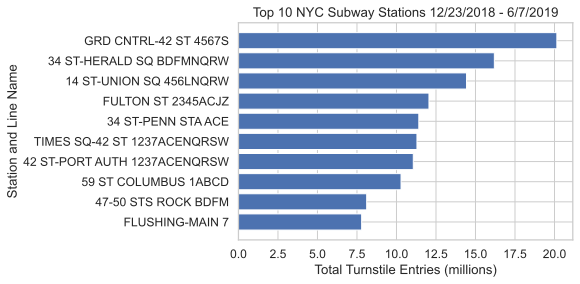

In [107]:
#same as above, without static references to the indices we want
plt.barh(station_totals['STATION_AND_LINE'][:10], station_totals['DAILY_ENTRIES'][:10] / 1000000)
plt.yticks(rotation = 0, ticks = np.arange(10))
plt.ylabel('Station and Line Name')
plt.xlabel('Total Turnstile Entries (millions)')
plt.ticklabel_format(axis = 'x', style = 'plain')
plt.gca().invert_yaxis()
plt.title('Top 10 NYC Subway Stations 12/23/2018 - 6/7/2019')
plt.savefig('top_10_stations_2019.png', facecolor = 'w', dpi = 200, bbox_inches = 'tight');

In [59]:
station_daily['DATE'] = pd.to_datetime(station_daily['DATE'])

In [60]:
station_daily['DAY_OF_WEEK'] = station_daily['DATE'].dt.dayofweek

In [61]:
station_daily['DAY_OF_WEEK'] = station_daily['DAY_OF_WEEK'].map({0 : 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

In [62]:
station_daily.sort_values('DAILY_ENTRIES', ascending = False).head(20)

,STATION,LINENAME,DATE,DAILY_ENTRIES,STATION_AND_LINE,DAY_OF_WEEK
64405,PATH NEW WTC,1,2019-01-03,334720.0,PATH NEW WTC 1,Thursday
75878,WTC-CORTLANDT,1,2019-01-03,233747.0,WTC-CORTLANDT 1,Thursday
54071,JOURNAL SQUARE,1,2019-01-03,178230.0,JOURNAL SQUARE 1,Thursday
49620,GRD CNTRL-42 ST,4567S,2019-05-29,172071.0,GRD CNTRL-42 ST 4567S,Wednesday
49551,GRD CNTRL-42 ST,4567S,2019-03-21,171256.0,GRD CNTRL-42 ST 4567S,Thursday
49621,GRD CNTRL-42 ST,4567S,2019-05-30,169404.0,GRD CNTRL-42 ST 4567S,Thursday
49605,GRD CNTRL-42 ST,4567S,2019-05-14,168884.0,GRD CNTRL-42 ST 4567S,Tuesday
49537,GRD CNTRL-42 ST,4567S,2019-03-07,167906.0,GRD CNTRL-42 ST 4567S,Thursday
49586,GRD CNTRL-42 ST,4567S,2019-04-25,167562.0,GRD CNTRL-42 ST 4567S,Thursday
49535,GRD CNTRL-42 ST,4567S,2019-03-05,167237.0,GRD CNTRL-42 ST 4567S,Tuesday


In [63]:
station_daily['NUMERIC_DAY_OF_WEEK'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek

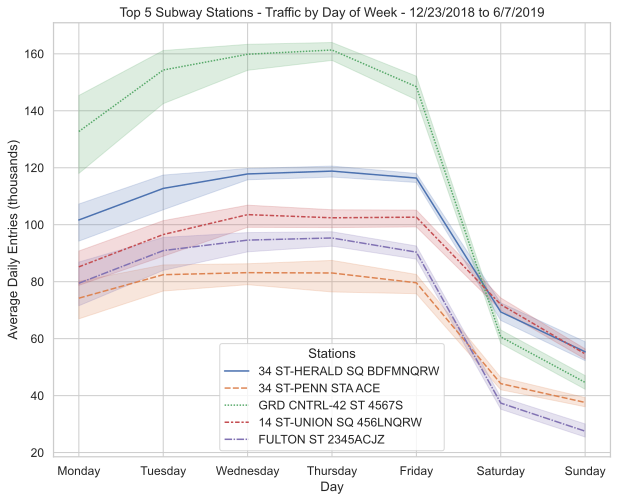

In [108]:
station_daily.sort_values('NUMERIC_DAY_OF_WEEK', ascending = True, inplace = True)
mask = station_daily['STATION_AND_LINE'].isin(['GRD CNTRL-42 ST 4567S', '34 ST-HERALD SQ BDFMNQRW', '14 ST-UNION SQ 456LNQRW', 'FULTON ST 2345ACJZ', '34 ST-PENN STA ACE'])

fig, ax = plt.subplots(figsize = (10, 8))
g = sns.lineplot(data = station_daily[mask], x = station_daily[mask]['DAY_OF_WEEK'], y = station_daily[mask]['DAILY_ENTRIES'] / 1000, style = station_daily[mask]['STATION_AND_LINE'], hue = station_daily[mask]['STATION_AND_LINE'])

ax.legend(title = 'Stations', loc = 'lower center')
g.set_title('Top 5 Subway Stations - Traffic by Day of Week - 12/23/2018 to 6/7/2019')
g.set_xlabel("Day")
g.set_ylabel("Average Daily Entries (thousands)")
fig.savefig("daily_traffic_2019.png", dpi = 200, facecolor = 'w');

In [65]:
station_daily['NUMERIC_MONTH'] = pd.to_datetime(station_daily['DATE']).dt.month
months = {1 : 'January',
         2 : 'February',
         3 : 'March',
         4 : 'April',
         5 : 'May',
         6 : 'June',
         7 : 'July',
         8 : 'August',
         9 : 'September',
         10 : 'October',
         11 : 'November',
         12 : 'December'}
station_daily['MONTH'] = station_daily['NUMERIC_MONTH'].map(months)
station_daily

,STATION,LINENAME,DATE,DAILY_ENTRIES,STATION_AND_LINE,DAY_OF_WEEK,NUMERIC_DAY_OF_WEEK,NUMERIC_MONTH,MONTH
76371,ZEREGA AV,6,2018-12-31,1747.0,ZEREGA AV 6,Monday,0,12,December
43313,DYCKMAN ST,A,2019-03-11,6850.0,DYCKMAN ST A,Monday,0,3,March
43306,DYCKMAN ST,A,2019-03-04,5065.0,DYCKMAN ST A,Monday,0,3,March
11105,23 ST,6,2019-05-20,28592.0,23 ST 6,Monday,0,5,May
43299,DYCKMAN ST,A,2019-02-25,6748.0,DYCKMAN ST A,Monday,0,2,February
...,...,...,...,...,...,...,...,...,...
34712,BRIGHTON BEACH,BQ,2019-05-05,4962.0,BRIGHTON BEACH BQ,Sunday,6,5,May
61880,NEWARK HM HE,1,2019-04-28,0.0,NEWARK HM HE 1,Sunday,6,4,April
34705,BRIGHTON BEACH,BQ,2019-04-28,5134.0,BRIGHTON BEACH BQ,Sunday,6,4,April
13977,34 ST-HERALD SQ,BDFMNQRW,2019-03-17,63203.0,34 ST-HERALD SQ BDFMNQRW,Sunday,6,3,March


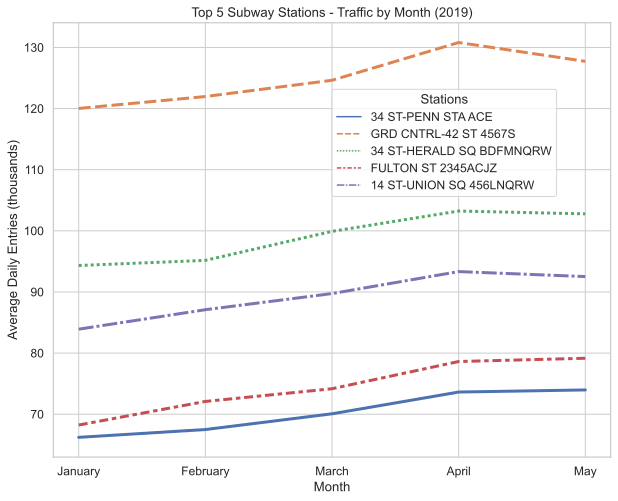

In [109]:
station_daily.sort_values('NUMERIC_MONTH', ascending = True, inplace = True)
mask = (station_daily['STATION_AND_LINE'].isin(['GRD CNTRL-42 ST 4567S', '34 ST-HERALD SQ BDFMNQRW', '14 ST-UNION SQ 456LNQRW', 'FULTON ST 2345ACJZ', '34 ST-PENN STA ACE'])) \
        & (station_daily['NUMERIC_MONTH'].isin([1, 2, 3, 4, 5]))
fig, ax = plt.subplots(figsize = (10, 8))

g = sns.lineplot(data = station_daily[mask], x = station_daily[mask]['MONTH'], y = station_daily[mask]['DAILY_ENTRIES'] \
             / 1000, style = station_daily[mask]['STATION_AND_LINE'], \
             hue = station_daily[mask]['STATION_AND_LINE'], ci = None, linewidth = 3)

ax.legend(loc = (.5, .6), title = 'Stations')
g.set_title('Top 5 Subway Stations - Traffic by Month (2019)')
g.set_xlabel("Month")
g.set_ylabel("Average Daily Entries (thousands)")
fig.savefig("monthly_traffic_2019.png", dpi = 200, facecolor = 'w');

In [70]:
all_data.groupby(['STATION', 'LINENAME', 'DATE', 'TIME_OF_DAY'], as_index = False).head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY
4886790,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/06/2019,09:00:00,REGULAR,5554,379,2019-06-06 09:00:00,Mid-Morning
4886789,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/06/2019,05:00:00,REGULAR,5554,379,2019-06-06 05:00:00,Early Morning
4886788,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/06/2019,01:00:00,REGULAR,5554,379,2019-06-06 01:00:00,Late Night
4886787,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2019,21:00:00,REGULAR,5554,379,2019-06-05 21:00:00,Night
4886786,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2019,17:00:00,RECOVR AUD,5554,379,2019-06-05 17:00:00,Late Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655432,A002,R051,02-05-00,59 ST,456NQRW,BMT,05/03/2019,11:40:35,REGULAR,124,0,2019-05-03 11:40:35,Mid-Morning
2636758,A002,R051,02-05-00,59 ST,456NQRW,BMT,03/29/2019,11:01:44,REGULAR,111,0,2019-03-29 11:01:44,Mid-Morning
2232240,A002,R051,02-05-00,59 ST,456NQRW,BMT,03/13/2019,11:50:03,REGULAR,107,0,2019-03-13 11:50:03,Mid-Morning
2232195,A002,R051,02-03-06,59 ST,456NQRW,BMT,03/13/2019,11:50:03,REGULAR,8883545,497318,2019-03-13 11:50:03,Mid-Morning


In [71]:
all_data.sort_values(['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME','DATE_TIME'], ascending = False, inplace = True)
turnstiles_hourly = all_data

In [72]:
#have to reduce date range to perform diff operations, smaller data set
mask = (turnstiles_hourly['DATE_TIME'].dt.date >= datetime(2019, 4, 7).date()) & (turnstiles_hourly['DATE_TIME'].dt.date <= datetime(2019, 4, 13).date())
turnstiles_hourly = turnstiles_hourly[mask].copy()

In [73]:
turnstiles_hourly['TOD_ENTRIES'] = turnstiles_hourly['ENTRIES'].diff()

In [74]:
turnstiles_hourly['TOD_EXITS'] = turnstiles_hourly['EXITS'].diff()

In [75]:
turnstiles_hourly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204823 entries, 3451102 to 3043887
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CA           204823 non-null  object        
 1   UNIT         204823 non-null  object        
 2   SCP          204823 non-null  object        
 3   STATION      204823 non-null  object        
 4   LINENAME     204823 non-null  object        
 5   DIVISION     204823 non-null  object        
 6   DATE         204823 non-null  object        
 7   TIME         204823 non-null  object        
 8   DESC         204823 non-null  object        
 9   ENTRIES      204823 non-null  int64         
 10  EXITS        204823 non-null  int64         
 11  DATE_TIME    204823 non-null  datetime64[ns]
 12  TIME_OF_DAY  204823 non-null  category      
 13  TOD_ENTRIES  204822 non-null  float64       
 14  TOD_EXITS    204822 non-null  float64       
dtypes: category(1), datetime64[

In [76]:
turnstiles_hourly.dropna(how = 'any', axis = 0, inplace = True)

In [77]:
mask = turnstiles_hourly['TOD_EXITS'] < 0
turnstiles_hourly[mask]['TOD_EXITS'].describe()

count    1.717650e+05
mean    -8.386900e+05
std      3.159859e+07
min     -2.118992e+09
25%     -2.110000e+02
50%     -7.900000e+01
75%     -2.300000e+01
max     -1.000000e+00
Name: TOD_EXITS, dtype: float64

In [78]:
turnstiles_hourly['TOD_ENTRIES'] = turnstiles_hourly['TOD_ENTRIES'].apply(lambda x : abs(x))
turnstiles_hourly['TOD_EXITS'] = turnstiles_hourly['TOD_EXITS'].apply(lambda x : abs(x))

In [80]:
turnstiles_hourly['TOD_EXITS'].describe()

count    2.048220e+05
mean     1.406673e+06
std      4.111176e+07
min      0.000000e+00
25%      9.000000e+00
50%      5.700000e+01
75%      1.860000e+02
max      2.118992e+09
Name: TOD_EXITS, dtype: float64

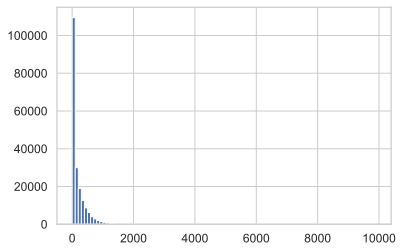

In [97]:
mask = (turnstiles_hourly['STATION'] == 'GRD CNTRL-42 ST') # & (turnstiles_hourly['DATE_TIME'].dt.date == datetime(2019,4,9).date())
plt.hist(turnstiles_hourly['TOD_ENTRIES'], bins = np.arange(0, 10000, 100));

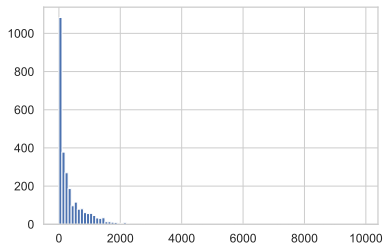

In [101]:
mask = (turnstiles_hourly['STATION'] == 'GRD CNTRL-42 ST') # & (turnstiles_hourly['DATE_TIME'].dt.date == datetime(2019,4,9).date())
plt.hist(turnstiles_hourly[mask]['TOD_ENTRIES'], bins = np.arange(0, 10000, 100));

In [69]:
turnstiles_hourly.describe()

,ENTRIES,EXITS,TOD_ENTRIES,TOD_EXITS
count,2.099450e+05,2.099450e+05,2.099450e+05,2.099450e+05
mean,4.134294e+07,3.318906e+07,1.740880e+06,1.432499e+06
std,2.164415e+08,1.916038e+08,4.594661e+07,4.093334e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.204590e+05,9.409300e+04,2.000000e+00,4.000000e+00
50%,1.461798e+06,8.756270e+05,2.200000e+01,2.400000e+01
75%,6.081545e+06,4.030031e+06,7.800000e+01,7.800000e+01
max,2.128699e+09,2.122964e+09,2.128495e+09,2.122640e+09


In [104]:
mask = (turnstiles_hourly['TOD_ENTRIES'] < 10000) & (turnstiles_hourly['TOD_EXITS'] < 10000)
turnstiles_hourly = turnstiles_hourly[mask].copy()
turnstiles_hourly.describe()

,ENTRIES,EXITS,TOD_ENTRIES,TOD_EXITS
count,2.001020e+05,2.001020e+05,200102.000000,200102.000000
mean,4.113166e+07,3.377792e+07,182.425433,142.449336
std,2.114088e+08,1.953959e+08,277.419952,250.118453
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3.608102e+05,1.530145e+05,10.000000,8.000000
50%,2.231070e+06,1.289865e+06,76.000000,54.000000
75%,6.779933e+06,4.631882e+06,249.000000,171.000000
max,2.129380e+09,2.124176e+09,9941.000000,9393.000000


In [105]:
turnstiles_hourly['STATION_AND_LINE'] = turnstiles_hourly['STATION'] + " " + turnstiles_hourly['LINENAME']

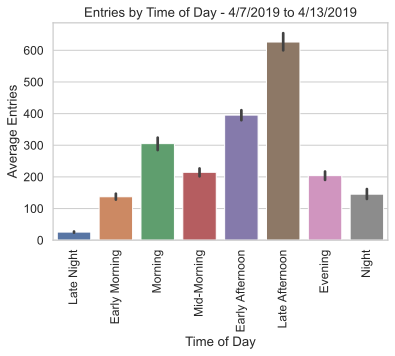

In [112]:
mask = turnstiles_hourly['STATION_AND_LINE'].isin(['GRD CNTRL-42 ST 4567S', '34 ST-HERALD SQ BDFMNQRW', '14 ST-UNION SQ 456LNQRW', 'FULTON ST 2345ACJZ', '34 ST-PENN STA ACE'])
# plt.bar(turnstiles_hourly[mask]['TIME_OF_DAY'], turnstiles_hourly[mask]['TOD_ENTRIES'])

sns.barplot(x = turnstiles_hourly[mask]['TIME_OF_DAY'], y = turnstiles_hourly[mask]['TOD_ENTRIES'])
plt.title('Entries by Time of Day - 4/7/2019 to 4/13/2019')
plt.ylabel('Average Entries')
plt.xlabel('Time of Day')
plt.xticks(rotation = 90)
plt.savefig('time_of_day_2019_top_5.png', facecolor = 'w', dpi = 200, bbox_inches = 'tight');
# decide on date range, stations to include before plotting. also look at entries vs. exits.